In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../src/')
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
from sklearn.base import clone
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from datetime import datetime

from preprocessing import BagOfNotes, MidiPathToDataFrame, PreprocessMidiDataFrame, NfIsf, BagOfChords2, Downsampler
import evaluation

In [11]:
data_dir = Path('../maestro/maestro-v3.0.0/')
# df = pd.read_csv(data_dir / 'maestro-v3.0.0.csv')
df = pd.read_csv('../eda/no_dups.csv', index_col=0)
keys = pd.read_csv('../eda/key_review.csv')
categories = pd.read_csv('../eda/categories.csv')
df = pd.merge(df, keys, how='left', on='canonical_title')
df = pd.merge(df, categories, how='left', on='canonical_title')
df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,draft_key,category
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160,NaN,sonata
1,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,NaN,prelude
2,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,NaN,etude
3,Alexander Scriabin,"5 Preludes, Op.15",validation,2009,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,400.557826,NaN,prelude
4,Alexander Scriabin,"Entragete, Op.63",test,2009,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,163.745830,NaN,NaN


In [12]:
test = df[df.split == 'test']
test.shape

(144, 9)

In [5]:
do_once = Pipeline([
    ('loader', MidiPathToDataFrame(data_dir)),
    ('cleaner', PreprocessMidiDataFrame()),
])
test_loaded = do_once.transform(test.midi_filename)


C:\Users\benkc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


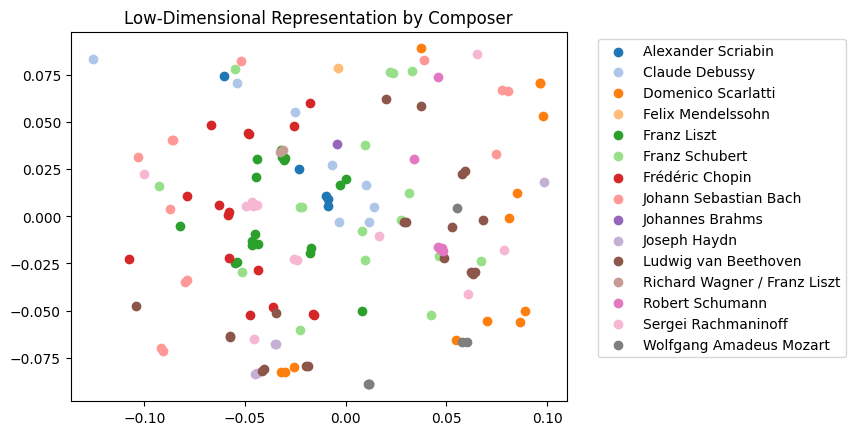

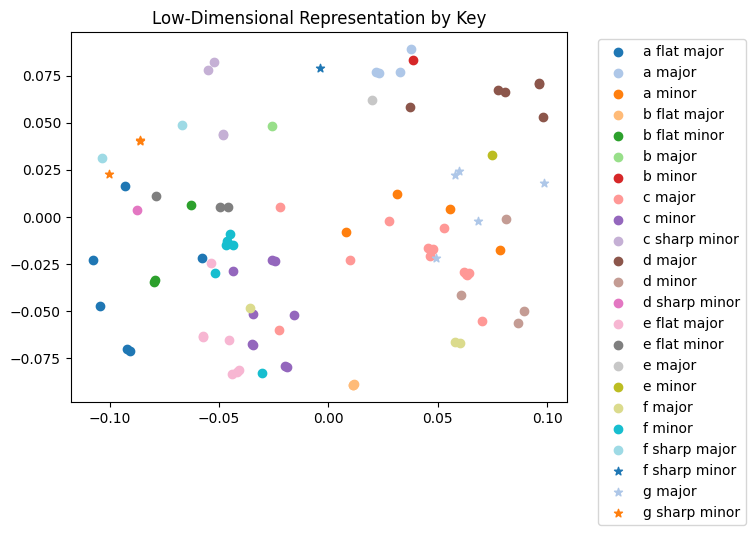

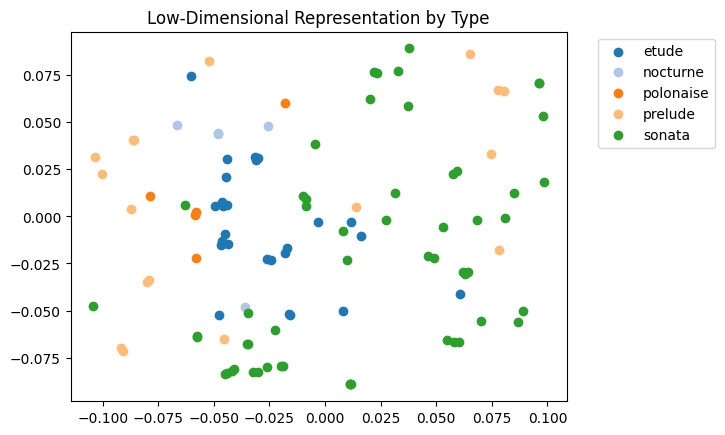

{'canonical_composer': 0.48613565068422, 'draft_key': 0.6892038246152055, 'category': 0.5200523592997732, 'silhouette': 0.2617122451911891}


In [39]:
name = 'nBoN-PCA2'
with open(f'{name.lower()}.pkl', 'rb') as f:
    model = pickle.load(f)
embeddings = model[:2].transform(test_loaded)
clusters = model[2].predict(embeddings)
scores = evaluation.evaluate_clusters(clusters, test[['canonical_composer', 'draft_key', 'category']])
for s in scores:
    title = f'Low-Dimensional Representation by {"Type" if s == "category" else s.split("_")[1].title()}'
    evaluation.plot_with_label(embeddings, test[s], title)
silhouette = silhouette_score(embeddings, clusters)
scores['silhouette'] = silhouette
print(scores)

In [28]:
numerical_mappings = [
    (-7, ['c flat major', 'a flat minor']),
    (-6, ['g flat major', 'e flat minor']),
    (-5, ['d flat major', 'b flat minor']),
    (-4, ['a flat major', 'f minor']),
    (-3, ['e flat major', 'c minor']),
    (-2, ['b flat major', 'g minor']),
    (-1, ['f major', 'd minor']),
    (0, ['c major', 'a minor']),
    (1, ['g major', 'e minor']),
    (2, ['d major', 'b minor']),
    (3, ['a major', 'f sharp minor']),
    (4, ['e major', 'c sharp minor']),
    (5, ['b major', 'g sharp minor']),
    (6, ['f sharp major', 'd sharp minor']),
    (7, ['c sharp major', 'a sharp minor']),
]
def numerical_key(key) -> str:
    for n, pair in numerical_mappings:
        if key in pair:
            return n
            # if n < 0:
            #     return f'{n} flats'
            # if n > 0:
            #     return f'{n} sharps'
            # return 'no sharps/flats'
    return np.nan


num_map = test.draft_key.apply(numerical_key)

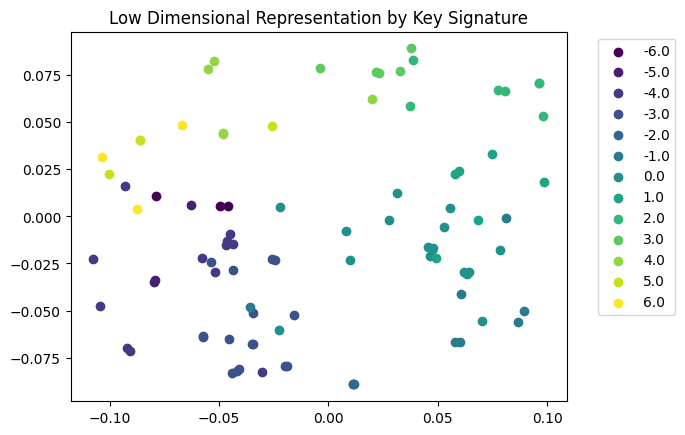

In [40]:
evaluation.plot_with_label_continuous(embeddings, num_map, f'Low Dimensional Representation by Key Signature')

In [41]:
test.category.value_counts()

category
sonata       56
etude        26
prelude      17
nocturne      5
polonaise     5
Name: count, dtype: int64